In [1]:
import numpy as np
from tqdm import trange
from gymnasium import spaces
from gymnasium.utils.env_checker import check_env

from flygym.simulation import SingleFlySimulation, Fly
from flygym.examples.common import PreprogrammedSteps
from flygym.examples.cpg_controller import CPGNetwork
from flygym.preprogrammed import get_cpg_biases
from hybrid_turning_fly import HybridTurningFly



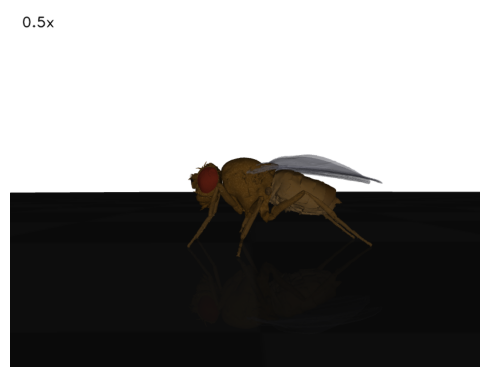

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
from flygym import Parameters, Camera, SingleFlySimulation, Fly
from flygym.examples.turning_controller import HybridTurningNMF
from flygym.simulation import Simulation
from hybrid_turning_fly import HybridTurningFly
from movodor_arena import MovOdorArena
seed = 1

# Odor source: array of shape (num_odor_sources, 3) - xyz coords of odor sources
odor_source = np.array([[24, 10, 1.5]])

# Peak intensities: array of shape (num_odor_sources, odor_dimensions)
# For each odor source, if the intensity is (x, 0) then the odor is in the 1st dimension
# (in this case attractive). If it's (0, x) then it's in the 2nd dimension (in this case
# aversive)
peak_odor_intensity = np.array([[1, 0]])

# Marker colors: array of shape (num_odor_sources, 4) - RGBA values for each marker,
# normalized to [0, 1]
marker_colors = [[255, 127, 14]]
marker_colors = np.array([[*np.array(color) / 255, 1] for color in marker_colors])

odor_dimensions = len(peak_odor_intensity[0])
arena = MovOdorArena(
    size=(300, 300),
    friction=(1, 0.005, 0.0001),
    num_sensors=4,
    move_speed=0,
    move_direction="right",
    odor_source=odor_source,
    peak_intensity=peak_odor_intensity,
    diffuse_func=lambda x: x**-2,
    marker_colors=marker_colors,
    marker_size=0.3,
)

sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.5,
    render_window_size=(800, 608),
    enable_olfaction=True,
    enable_adhesion=True,
    draw_adhesion=False,
    render_camera="Animat/camera_left",
)
timestep = sim_params.timestep
fly_male = Fly(
    name="male",
    
    enable_adhesion=True,
    enable_olfaction=True,
    spawn_pos=(0, 0, 0.2),
)

cam = Camera(
    fly=fly_male,
    camera_id="Animat/camera_left",
    window_size=(800, 608),
    play_speed=0.5,
)

sim = SingleFlySimulation(
    fly=fly_male,
    cameras=[cam],
    arena=arena,
    timestep=timestep,
)

preprogrammed_step = PreprogrammedSteps()
legs=preprogrammed_step.legs
swing_period=preprogrammed_step.swing_period
standing_action=[]
for leg in legs:
    if leg.endswith("M"):
        standing_action.extend(preprogrammed_step.get_joint_angles(leg,swing_period[leg][1]))
    else:
        standing_action.extend(preprogrammed_step.get_joint_angles(leg,0.0))

stand_action={'joints':np.array(standing_action),'adhesion':np.zeros(len(legs))}

for i in range(int(0.2//sim.timestep)):
    sim.step(stand_action)
    sim.render()
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.imshow(cam._frames[-1])
ax.axis("off")
fig.savefig("./outputs/olfaction_env.png")

In [15]:
run_time= 1
target_num_steps = int(run_time / sim_params.timestep)
forelegs_ids=np.zeros(target_num_steps)
middle_stance_ids=np.linspace(swing_period["RM"][1],2*np.pi,target_num_steps)
hind_swings_ids=np.linspace(0,swing_period["RH"][1],target_num_steps)

adhesion_action=np.array([0.0 if leg.endswith("F") else 1.0 for leg in legs])
all_joint_angles=[]

for i in range(target_num_steps):
    joint_angles=[]
    for leg in legs:
        if leg.endswith("F"):
            joint_angles.extend(preprogrammed_step.get_joint_angles(leg,forelegs_ids[i]))
        elif leg.endswith("M"):
            joint_angles.extend(preprogrammed_step.get_joint_angles(leg,middle_stance_ids[i]))
        else:
            joint_angles.extend(preprogrammed_step.get_joint_angles(leg,hind_swings_ids[i]))
    all_joint_angles.append(joint_angles.copy())
    action={'joints':np.array(joint_angles),'adhesion':adhesion_action}
    sim.step(action)
    sim.render()

from IPython.display import Video

cam.save_video("./outputs/lunging3_video.mp4")

Video("./outputs/lunging3_video.mp4", width=800, height=608)


In [7]:

import pickle
from flygym.util import get_data_path
from scipy.interpolate import CubicSpline

run_time= 5
target_num_steps = int(run_time / sim_params.timestep)
actuated_joints=preprogrammed_step.dofs_per_leg
path = (get_data_path("flygym", "data") / "behavior/single_steps_untethered.pkl"
            )
with open(path, "rb") as f:
        data = pickle.load(f)





data["joint_LFCoxa"]=np.concatenate([np.linspace(0.6, -0.2, 200),np.linspace(-0.2, -0.2, 100),np.linspace(-0.2, -0.21, 200),np.linspace(-0.2, -0.2, 300),np.linspace(-0.2,0.2, 200)]).tolist()
data["joint_LFCoxa_roll"]=np.concatenate([np.linspace(0, 0, 200), np.linspace(0, 0, 100),np.linspace(0, 0, 200),np.linspace(0, 0, 300),np.linspace(0, 0, 200)]).tolist()
data["joint_LFCoxa_yaw"]=np.concatenate([np.linspace(-0.7,-1, 200),np.linspace(-1,-1, 100),np.linspace(-1,-1, 200),np.linspace(-1, -1, 300),np.linspace(-1, -1, 200)]).tolist()
data["joint_LFFemur"]=np.concatenate([np.linspace(-2.39,-2.1, 200),np.linspace(-2.1, -2.1, 100), np.linspace(-2.1, -1.1, 200),np.linspace(-1.1,-1.1, 300),np.linspace(-1.1,-1.1, 200)]).tolist()
data["joint_LFFemur_roll"]=np.concatenate([np.linspace(0,-1, 200),np.linspace(-1, -1, 100),np.linspace(-1,-1, 200),np.linspace(-1, -1, 300),np.linspace(-1, -1, 200)]).tolist()
data["joint_LFTibia"]=np.concatenate([np.linspace(1.67,1.0, 200),np.linspace(1, 1.0, 100),np.linspace(1.0, 0.11, 200),np.linspace(0.11, 0.11, 300),np.linspace(0.11, 0.11, 200)]).tolist()
data["joint_LFTarsus1"]=np.concatenate([np.linspace(0.5,0.21 ,200),np.linspace(0.21,0.21,100),np.linspace(0.2,0.11 , 200),np.linspace(0.11, 0.11, 300),np.linspace(0.11, 0.11, 200)]).tolist()

data["joint_LMCoxa"]=np.concatenate([np.linspace(0.11,0.12, 200),np.linspace(0.12,0.12, 100),np.linspace(0.12,0.52, 200),np.linspace(0.52, 2, 300),np.linspace(2, -0.3, 200)]).tolist()
data["joint_LMCoxa_roll"]=np.concatenate([np.linspace(0.1,0.1 , 200),np.linspace(0.1,0.1 , 100),np.linspace(0.1,0.1 , 200),np.linspace(0.1, 0.1, 300),np.linspace(0.1, 0.1, 200)]).tolist()
data["joint_LMCoxa_yaw"]=np.concatenate([np.linspace(0.2,0.2, 200),np.linspace(0.2,0.2, 100),np.linspace(0.2,0.2, 200),np.linspace(0.2, 0.3, 300),np.linspace(0.3, 0.3, 200)]).tolist()
data["joint_LMFemur"]=np.concatenate([np.linspace(-1.98,-0.998 , 200),np.linspace(-0.998,-0.998, 100),np.linspace(-0.998,-0.598, 200),np.linspace(-0.598, -0.698, 300),np.linspace(-0.698, -1, 200)]).tolist()
data["joint_LMFemur_roll"]=np.concatenate([np.linspace(0,0 , 200,),np.linspace(0,0 , 100),np.linspace(0,0 , 200),np.linspace(0, 0, 300),np.linspace(0, 0, 200)]).tolist()
data["joint_LMTibia"]=np.concatenate([np.linspace(1.74,0.5, 200),np.linspace(0.50,0.5, 100),np.linspace(0.52,0.2, 200),np.linspace(0.2, 0.2, 300),np.linspace(0.2, 1.7, 200)]).tolist()
data["joint_LMTarsus1"]=np.concatenate([np.linspace(-0.6,-0.23 , 200),np.linspace(-0.233,-0.23 , 100),np.linspace(-0.233,-0.1 , 200),np.linspace(-0.1, -0.2, 300),np.linspace(-0.2, -1.2, 200)]).tolist()

data["joint_LHCoxa"]=np.concatenate([np.linspace(0.4,0.21, 200),np.linspace(0.21,0.21, 100),np.linspace(0.21,-0.6, 200),np.linspace(-0.6, -0.6, 300),np.linspace(-0.6, 0.21, 200)]).tolist()
data["joint_LHCoxa_roll"]=np.concatenate([np.linspace(2.5,2.41, 200),np.linspace(2.4,2.41, 100),np.linspace(2.4,2.41, 200),np.linspace(2.41, 2.41, 300),np.linspace(2.41, 2.41, 200)]).tolist()
data["joint_LHCoxa_yaw"]=np.concatenate([np.linspace(-0.07,0.6, 200),np.linspace(0.6, 0.6, 100),np.linspace(0.6, 0.6, 200),np.linspace(0.6, 0.6, 300),np.linspace(0.6, -0.3, 200)]).tolist()
data["joint_LHFemur"]=np.concatenate([np.linspace(-2.01,-1.82 ,200),np.linspace(-1.82,-1.82 ,100),np.linspace(-1.8,-0.1 , 200),np.linspace(-0.1, -0.1, 300),np.linspace(-0.1, -0.5, 200)]).tolist()
data["joint_LHFemur_roll"]=np.concatenate([np.linspace(0.18,0.191 , 200),np.linspace(0.19,0.191 , 100),np.linspace(0.19,0.191 , 200),np.linspace(0.191, 0.191, 300),np.linspace(0.191, 0.191, 200)]).tolist()
data["joint_LHTibia"]=np.concatenate([np.linspace(2.07,2.15, 200),np.linspace(2.15,2.15, 100),np.linspace(2.15,0.1, 200),np.linspace(0.1, 0.1, 300),np.linspace(0.1, 0.8, 200)]).tolist()
data["joint_LHTarsus1"]=np.concatenate([np.linspace(-0.53,-1.0, 200),np.linspace(-1.0,-1.0, 100),np.linspace(-1.0,-0.2, 200),np.linspace(-0.2, -0.2, 300),np.linspace(-0.2, -0.5, 200)]).tolist()


data["joint_RFCoxa"]=data["joint_LFCoxa"]
data["joint_RFCoxa_roll"]=[-x for x in data["joint_LFCoxa_roll"]]
data["joint_RFCoxa_yaw"]=[-x for x in data["joint_LFCoxa_yaw"]]
data["joint_RFFemur"]=data["joint_LFFemur"]
data["joint_RFFemur_roll"]=[-x for x in data["joint_LFFemur_roll"]]
data["joint_RFTibia"]=data["joint_LFTibia"]
data["joint_RFTarsus1"]=data["joint_LFTarsus1"]

data["joint_RMCoxa"]=data["joint_LMCoxa"]
data["joint_RMCoxa_roll"]=[-x for x in data["joint_LMCoxa_roll"]]
data["joint_RMCoxa_yaw"]=[-x for x in data["joint_LMCoxa_yaw"]]
data["joint_RMFemur"]=data["joint_LMFemur"]
data["joint_RMFemur_roll"]=[-x for x in data["joint_LMFemur_roll"]]
data["joint_RMTibia"]=data["joint_LMTibia"]


preprogrammed_step.single_steps_data= data

all_joint_angles=[]

for i in range(target_num_steps):
    joint_angles=[]
    for leg in legs:
        if leg.endswith("F"):
            joint_angles.extend(preprogrammed_step.get_joint_angles(leg,forelegs_ids[i]))
        elif leg.endswith("M"):
            joint_angles.extend(preprogrammed_step.get_joint_angles(leg,middle_stance_ids[i]))
        else:
            joint_angles.extend(preprogrammed_step.get_joint_angles(leg,hind_swings_ids[i]))
    all_joint_angles.append(joint_angles.copy())
    action={'joints':np.array(joint_angles),'adhesion':adhesion_action}
    sim.step(action)
    sim.render()


IndexError: index 10000 is out of bounds for axis 0 with size 10000

In [9]:
cam.save_video("./outputs/lunging_force_video.mp4")

Video("./outputs/lunging_force_video.mp4", width=800, height=608)